In [ ]:
#!pip install flopy

In [1]:
# Temporal, para agregar las rutas correctas
%run ../../src/xmf6/ruta_temporal.py
if not(src_path in sys.path[0]):
    sys.path.insert(0, os.path.abspath(a_path + src_path)) 

In [2]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt

import flopy
from flopy.plot.styles import styles
import xmf6
##from flow_1D import build_gwf_1D
##from tran_1D import build_gwt_1D
# Funciones para cálculo de la solución analítica
##from wexler1 import sol_analytical_t
# Definición de parámetros de decaimiento y sorción
##from sorption_decay import *

In [3]:
os_par = dict(
    ws = os.getcwd() + '/output', # Ruta de donde estamos actualmente
    mf6_exe = '/home/jovyan/GMMC/WMA/mf6/bin/mf6', # Ejecutable
    flow_name = 'flow', # Nombre de la simulación para flujo
    tran_name = 'transport' # Nombre de la simulación para transporte
)
xmf6.nice_print(os_par, 'MODFLOW 6 environment')
                     
oc_par = dict(
    head_file = f"{os_par['flow_name']}.hds",
    fbudget_file = f"{os_par['flow_name']}.bud",
    concentration_file=f"{os_par['tran_name']}.ucn",
    tbudget_file = f"{os_par['tran_name']}.bud",
)
xmf6.nice_print(oc_par, 'Output files')


MODFLOW 6 environment
------------------------------
                  ws = /home/jovyan/GMMC/WMA/notebooks/2_Transporte_mf6_1D/output
             mf6_exe = /home/jovyan/GMMC/WMA/mf6/bin/mf6
           flow_name = flow      
           tran_name = transport 

Output files
------------------------------
           head_file = flow.hds  
        fbudget_file = flow.bud  
  concentration_file = transport.ucn
        tbudget_file = transport.bud


In [4]:
# ----- Definición de Parámetros -----
mesh = xmf6.MeshDis(
    nrow = 1,    # Number of rows
    ncol = 120,  # Number of columns
    nlay = 1,    # Number of layers
    row_length = 12.0,    # Length of system ($cm$)
    column_length = 0.1,  # Length of system ($cm$)
    top = 1.0,   # Top of the model ($cm$)
    bottom = 0,  # Layer bottom elevation ($cm$)
)
xmf6.nice_print(mesh, 'Space discretization')

tdis = xmf6.TDis(
    perioddata = ((120, 240, 1.0),) # PERLEN, NSTP, TSMULT
)
xmf6.nice_print(tdis, 'Time discretization')


Space discretization
------------------------------
NX =          120 (ncol)
NY =            1 (nrow)
NZ =            1 (nlay)
LX =       12.000 (row)
LY =        0.100 (col)
LZ =        1.000 (lay)
DX =  1.00000e-01 (delr)
DY =  1.00000e-01 (delc)
TOP=        1.000 (top)
BOT=        0.000 (bottom)
DZ =  1.00000e+00 (top-botm)
0.5

Time discretization
------------------------------
      NPER = 1       
TOTAL TIME = 120.00
PER     PERLEN     NSTP     TSMULT        Dt1
  1     120.00      240       1.00   5.00e-01


In [5]:
ml_units = {
    "time": "seconds",
    "length": "centimeters"
}
xmf6.nice_print(ml_units, 'Units')

ph_par = dict(
    specific_discharge = 0.1,  # Specific discharge ($cm s^{-1}$)
    hydraulic_conductivity = 0.01,  # Hydraulic conductivity ($cm s^{-1}$)
    source_concentration = 1.0,  # Source concentration (unitless)
    porosity = 0.1,  # Porosity of mobile domain (unitless)
    initial_concentration = 0.0,  # Initial concentration (unitless)
    longitudinal_dispersivity = 1.0, # 0.1, 1.0, 1.0, 1.0
    retardation_factor = 1.0,        # 1.0, 1.0, 2.0, 1.0
    decay_rate =  0.0                # 0.1, 0.0, 0.0, 0.01
)
ph_par["dispersion_coefficient"] = ph_par["longitudinal_dispersivity"] * \
                                   ph_par["specific_discharge"] / ph_par["retardation_factor"]
xmf6.nice_print(ph_par, 'Physical parameters')


Units
------------------------------
                time = seconds   
              length = centimeters

Physical parameters
------------------------------
  specific_discharge = 0.1       
hydraulic_conductivity = 0.01      
source_concentration = 1.0       
            porosity = 0.1       
initial_concentration = 0.0       
longitudinal_dispersivity = 1.0       
  retardation_factor = 1.0       
          decay_rate = 0.0       
dispersion_coefficient = 0.1       


# Solución del flujo: GWF

In [6]:
from flow_1D import build_gwf_1D
sim_f, gwf = build_gwf_1D(mesh, tdis, ph_par, ml_units, os_par, oc_par)
sim_f.write_simulation(silent=True)
sim_f.run_simulation(silent=True)

(True, [])

In [7]:
of = xmf6.OFiles(gwf, os_par, oc_par)
head = of.get_head()
bud = of.get_bud()
spdis = of.get_spdis()
qx, _, _ = of.get_q()
xi = mesh.get_coords('X')

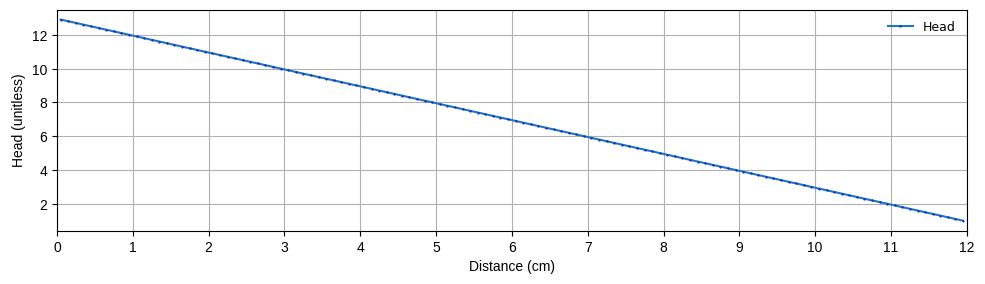

In [8]:
plt.figure(figsize=(10,3))
ax = plt.gca()
ax.set_xlim(0, 12)
ax.set_xticks(ticks=np.linspace(0, mesh.row_length,13))
ax.set_xlabel("Distance (cm)")
ax.set_ylabel("Head (unitless)")
ax.grid(True)
plt.tight_layout()
xmf6.plot1D(ax, xi, head[0, 0], savefig = False,
            marker=".", ls ="-", 
            mec="blue", mfc="none", 
            markersize="1", label = 'Head')

In [9]:
print(qx)

[[[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]]]


# Solución de transporte: DF IMP (Código de Leo)

## Introducción del modelo de flujo del WMA 
[4.1 - Definir una EDP para describir el proceso]

La ecuación de advección difusión que rige el transporte químico de una especie esta dada por:

$$R \frac{\partial c}{\partial t}= -q \nabla c + D_{H}\nabla^{2} c + S$$

donde el término fuente puede referirse a la recarga como sigue: $r(c_{r}-c)$, $R=1+\frac{k(\phi) \rho_{b}}{\theta}$ se le conoce como el factor de retardo (o de escalamiento), dividiendo todo por $R$:
$$ \frac{\partial c}{\partial t}= -q^{*} \nabla c + D_{H}^{*}\nabla^{2} c + S^{*}$$

**Condiciones de frontera e iniciales**

En las entradas:
$$ c_{inf}=1 $$
$$ D_{H}\frac{\partial c}{\partial x}=0 $$

Condiciones iniciales
$$c(x,0)=0$$  La concentración al tiempo "0" es igual a "0" en todo el dominio. 

In [10]:
solcnsImp_c = xmf6.df_implicit.solve(ph_par, mesh, tdis, qx)

|------------------------------------------------------------------------------|
|--------------SOLUCIÓN DIFERENCIAS FINITAS TRADICIONALES IMPLÍCITO------------|
|------------------------------------------------------------------------------|
tiempo de simulacion: 0.5 segundos
tiempo de simulacion: 1.0 segundos
tiempo de simulacion: 1.5 segundos
tiempo de simulacion: 2.0 segundos
tiempo de simulacion: 2.5 segundos
tiempo de simulacion: 3.0 segundos
tiempo de simulacion: 3.5 segundos
tiempo de simulacion: 4.0 segundos
tiempo de simulacion: 4.5 segundos
tiempo de simulacion: 5.0 segundos
tiempo de simulacion: 5.5 segundos
tiempo de simulacion: 6.0 segundos
tiempo de simulacion: 6.5 segundos
tiempo de simulacion: 7.0 segundos
tiempo de simulacion: 7.5 segundos
tiempo de simulacion: 8.0 segundos
tiempo de simulacion: 8.5 segundos
tiempo de simulacion: 9.0 segundos
tiempo de simulacion: 9.5 segundos
tiempo de simulacion: 10.0 segundos
tiempo de simulacion: 10.5 segundos
tiempo de simulacion

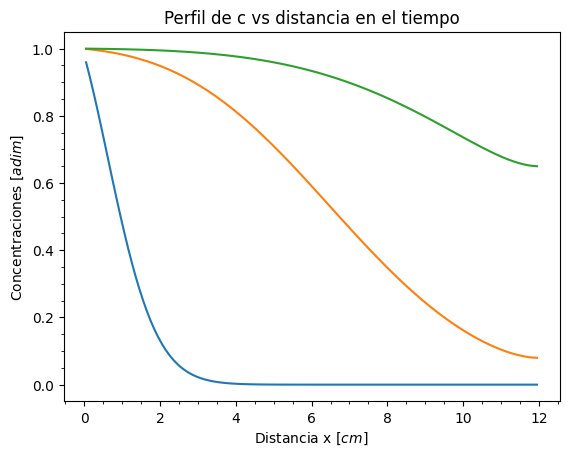

In [12]:
obs_data = [11, 119, 239]
xmf6.df_implicit.plot(xi, solcnsImp_c, obs_data)

In [ ]:
# Solución de transporte
sim_t, gwt = build_gwt_1D(mesh, tm_par, ph_par, ml_units, os_par, oc_par)
sim_t.write_simulation(silent=True)
sim_t.run_simulation(silent=True)
xmf6.plot_tran_1D(sim_t, mesh, tm_par, ph_par, os_par, oc_par)